In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta

import azure_db_service

In [4]:
historical_transactions = azure_db_service.get_data_from_historical_transactions()

In [5]:
print(*historical_transactions['idTag'].unique().tolist(), sep = "\n") 

04974FFAB63780
043661B2B63780
044627B2B63780
044D79B2B63780
043F57B2B63780
04557EFAB63780
045346FAB63780
044109B2B63780
046443FAB63780
048D4DFAB63780
044F0FFAB63780
04497EFAB63780
045121FAB63780
044F84B2B63780
0414478A134E80
04390EB2B63780
043D29B2B63780
045378B2B63780
047B65FAB63780
047E23FAB63780
044E18FAB63780
04560AFAB63780
04454EB2B63780
045167FAB63780
045388FAB63780
045359FAB63780
04833CFAB63780
938C77BC
04551EFAB63780
049246FAB63780
04515AB2B63780
B724FB5F
044E0FB2B63780
044F0CB2B63780
049139E2065580
044917FAB63780
04934AFAB63780
043122B2B63780
A66624011
043213B2B63780
04FE5642AB4880
045269FAB63780
045E50FAB63780
04357BB2B63780


In [6]:
def get_charging_times(userId, user_transactions):
    user_transactions = user_transactions.index.tolist()
    chargingTimes = []

    for transactionId in user_transactions:
        chargingTimes.append(get_charging_time(transactionId))
    
    return chargingTimes

In [7]:
def get_max_charging_timestamp(power_data):
    maxChargingTimestamp = power_data.iat[0, 0]
    found = False
    i = 1 #Start at 1 because normally the first value is 0
    while i < len(power_data) and not(found):
        value = power_data.iat[i, 1]
        if value == 0: 
            if power_data.iloc[i:i+91, 1].sum() == 0:
                maxChargingTimestamp = power_data.iat[i, 0]
                found = True
        i += 1
    
    return maxChargingTimestamp

In [8]:
def get_charging_time(transactionId):
    power_data = azure_db_service.get_power_data_from_meter_values(transactionId)
    
    power_data.drop(['PartitionKey', 'chargingStationId', 'connectorId'], axis=1, inplace=True)
    power_data.sort_values(by='timestampMeasurement', inplace=True)
    power_data['timestampMeasurement'] = pd.to_datetime(power_data['timestampMeasurement'])
    power_data['value'] = pd.to_numeric(power_data['value'])
    
    maxChargingTimestamp = get_max_charging_timestamp(power_data)
    minChargingTimestamp = power_data.iat[0, 0]
    diff = maxChargingTimestamp - minChargingTimestamp
    
    return diff.seconds/3600

In [9]:
def get_connection_times(userId, user_transactions):
    connectionTimes = []
    i = 0
    while i < len(user_transactions):
        stopTime = pd.to_datetime(user_transactions.iat[i, 12])
        startTime = pd.to_datetime(user_transactions.iat[i, 11])
        diff = stopTime - startTime
        connectionTimes.append(diff.seconds/3600)
        i += 1

    return connectionTimes

In [10]:
def plot_charging_and_connection_times(userId):
    user_transactions = historical_transactions[historical_transactions['idTag'] == userId]
    chargingTimes = get_charging_times(userId, user_transactions)
    connectionTimes = get_connection_times(userId, user_transactions)

    sns.set(rc={'figure.figsize':(16,8)})
    plt.plot( np.arange(1, len(chargingTimes) + 1), connectionTimes, marker='o', markerfacecolor='red', markersize=12, color='salmon', linewidth=2)
    plt.plot( np.arange(1, len(chargingTimes) + 1), chargingTimes, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
    plt.title('Charging and Connection Times for user ' + userId, fontsize=18)
    plt.xlabel('Transaction Number', fontsize=14)
    plt.ylabel('Charging Hours', fontsize=14)
    plt.legend(['Connection Time', 'Charging Time'], loc=0)

In [11]:
userId = '04974FFAB63780'

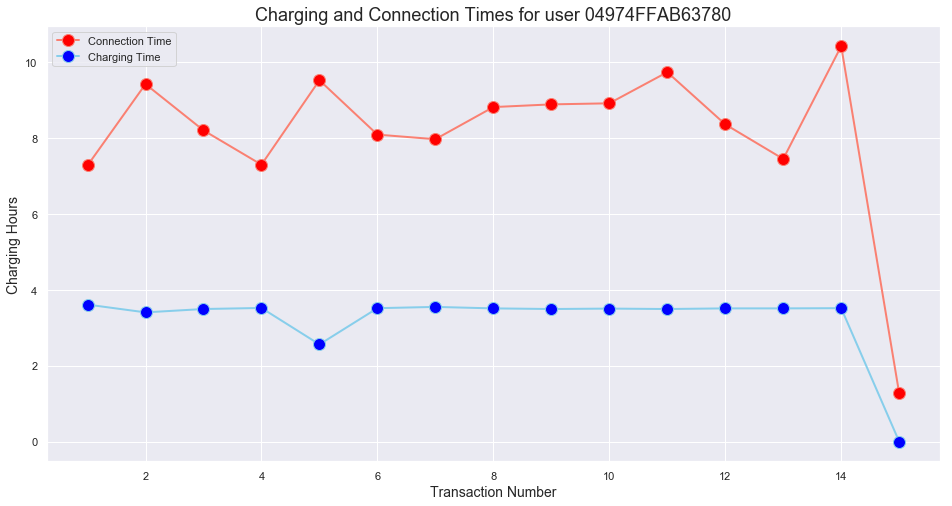

In [12]:
plot_charging_and_connection_times(userId)